### Installation of Dataset

In [1]:
!gdown 1-lySFdjCJi7Pl9Nz4KSM6SIqLPTCnNTq

Downloading...
From (original): https://drive.google.com/uc?id=1-lySFdjCJi7Pl9Nz4KSM6SIqLPTCnNTq
From (redirected): https://drive.google.com/uc?id=1-lySFdjCJi7Pl9Nz4KSM6SIqLPTCnNTq&confirm=t&uuid=fe2ebf0f-1a8e-4656-a3d7-28d689cc0e18
To: /content/Guestures.zip
100% 15.0M/15.0M [00:00<00:00, 30.6MB/s]


In [ ]:
!unzip Guestures.zip

### DatasetPrep

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

In [10]:
# Parameters
IMG_SIZE = (50, 50)
PATCH_SIZE = 16
EMBED_DIM = 64
NUM_HEADS = 4
FF_DIM = 128
NUM_LAYERS = 4
NUM_CLASSES = 6
BATCH_SIZE = 32
EPOCHS = 5

In [7]:
# Load dataset
def load_data(data_dir):
    images, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
            labels.append(label)

    images = np.array(images, dtype=np.float32) / 255.0
    images = np.expand_dims(images, axis=-1)
    labels = keras.utils.to_categorical(labels, NUM_CLASSES)
    return train_test_split(images, labels, test_size=0.2, random_state=42)

data_dir = "/content/Guestures"
X_train, X_test, y_train, y_test = load_data(data_dir)

In [13]:

# CNN Feature Extractor
def cnn_feature_extractor():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten()
    ])
    return model

# Vision Transformer Encoder Layer
def transformer_block(inputs):
    x = layers.LayerNormalization()(inputs)
    x = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(x, x)
    x = layers.Add()([x, inputs])
    x = layers.LayerNormalization()(x)
    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = layers.Dense(EMBED_DIM)(x)
    x = layers.Add()([x, inputs])
    return x

# Vision Transformer Model
def vit_classifier(input_shape):
    inputs = keras.Input(shape=input_shape)

    # CNN Feature Extraction
    cnn_model = cnn_feature_extractor()
    x = cnn_model(inputs)

    num_patches = 4608 // PATCH_SIZE
    x = layers.Reshape((num_patches, PATCH_SIZE))(x)
    x = layers.Dense(EMBED_DIM)(x)

    # Transformer Layers
    for _ in range(NUM_LAYERS):
        x = transformer_block(x)

    # Classification Head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return keras.Model(inputs, outputs)

In [38]:
# Build model
model = vit_classifier((50, 50, 1))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history=model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.2832 - loss: 1.6795 - val_accuracy: 0.8689 - val_loss: 0.3213
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9380 - loss: 0.1605 - val_accuracy: 0.9994 - val_loss: 0.0035
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 1.0000 - loss: 4.6526e-04 - val_accuracy: 1.0000 - val_loss: 5.0058e-04
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 1.0000 - loss: 1.2037e-04 - val_accuracy: 1.0000 - val_loss: 1.2701e-04


In [16]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.2982e-04
Test Accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


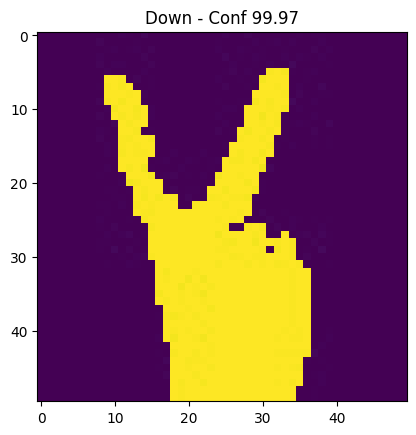

In [35]:
import matplotlib.pyplot as plt

results=["Close","Down","Left","Open","Right","Up"]
def PredictMe(image):
  img=cv2.imread(image,0)
  img=cv2.resize(img,(50,50))
  img=img/255
  img=np.expand_dims(img, axis=0)
  ans=model.predict(img)[0]
  conf=round(max(ans)*100,2)
  result=np.argmax(ans)
  predicted=results[result]
  plt.subplot(1,1,1)
  plt.imshow(img[0])
  plt.title(predicted+f" - Conf {conf}")
  plt.show()
PredictMe("/content/Guestures/Down/1.jpg")

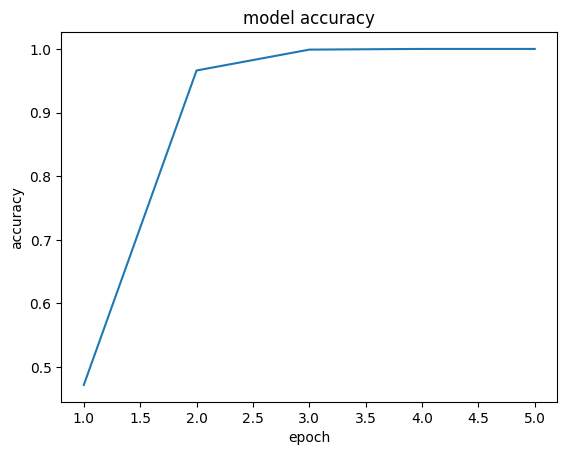

In [44]:
plt.plot(range(1,6),history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("Hybrid-Vit.h5")